In [ ]:
# Step 1: Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Step 2: Import libraries
import pandas as pd

# Step 3: Load the CSV files
stock_path = "/content/drive/My Drive/datathon 2025/all_stocks_and_etfs.csv"
gasoline_path = "/content/drive/My Drive/datathon 2025/weekly_gasoline_prices.csv"

stock_df = pd.read_csv(stock_path)
gasoline_df = pd.read_csv(gasoline_path)

# Step 4: Parse dates correctly
stock_df['Date-Time'] = pd.to_datetime(stock_df['Date-Time'])
gasoline_df['Date'] = pd.to_datetime(gasoline_df['Date'], errors='coerce')

# Optional check
print("Stock date range:", stock_df['Date-Time'].min(), "to", stock_df['Date-Time'].max())
print("Gasoline date range:", gasoline_df['Date'].min(), "to", gasoline_df['Date'].max())

# Step 5: Create a daily gasoline price DataFrame using forward fill
full_range = pd.DataFrame({'Date-Time': pd.date_range(start=stock_df['Date-Time'].min(),
                                                      end=stock_df['Date-Time'].max())})
gasoline_daily = pd.merge(full_range, gasoline_df.rename(columns={'Date': 'Date-Time'}), on='Date-Time', how='left')
gasoline_daily['Price'] = gasoline_daily['Price'].ffill()

# Step 6: Merge with stock data
merged_df = pd.merge(stock_df, gasoline_daily, on='Date-Time', how='left')

# Step 7: Save the merged file
output_path = "/content/drive/My Drive/datathon 2025/merged_stock_and_gasoline.csv"
merged_df.to_csv(output_path, index=False)

print(f"Merge successful. File saved to: {output_path}")


Mounted at /content/drive
Stock date range: 1999-11-01 00:00:00 to 2024-02-01 00:00:00
Gasoline date range: 2000-01-03 00:00:00 to 2023-12-25 00:00:00


KeyboardInterrupt: 

rolling correlation:

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


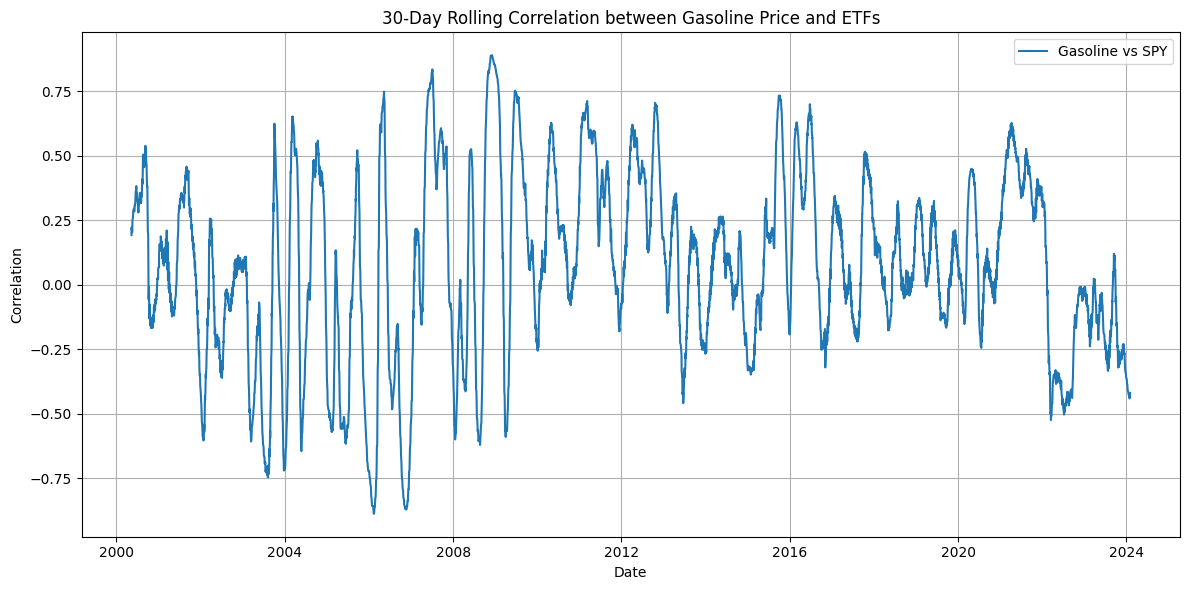

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
import pandas as pd
import matplotlib.pyplot as plt


file_path = "/content/drive/My Drive/datathon 2025/merged_stock_and_gasoline.csv"
df = pd.read_csv(file_path)


df['Date-Time'] = pd.to_datetime(df['Date-Time'])
df = df[['Date-Time', 'Ticker_Symbol', 'Close', 'Price']].dropna()


# Use pivot_table to avoid duplicate issues (aggregating duplicates with mean)
pivot_df = df.pivot_table(index='Date-Time', columns='Ticker_Symbol', values='Close', aggfunc='mean')


gas_price = df.drop_duplicates(subset='Date-Time')[['Date-Time', 'Price']].set_index('Date-Time')
pivot_df = pivot_df.merge(gas_price, left_index=True, right_index=True)

# Reconstruct: calculate rolling correlation manually for each ticker
tickers = ['SPY']

plt.figure(figsize=(12, 6))

for ticker in tickers:
    if ticker in pivot_df.columns:
        corr_series = pivot_df[ticker].rolling(window=90).corr(pivot_df['Price'])
        plt.plot(corr_series, label=f'Gasoline vs {ticker}')

plt.title("30-Day Rolling Correlation between Gasoline Price and ETFs")
plt.ylabel("Correlation")
plt.xlabel("Date")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()




Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


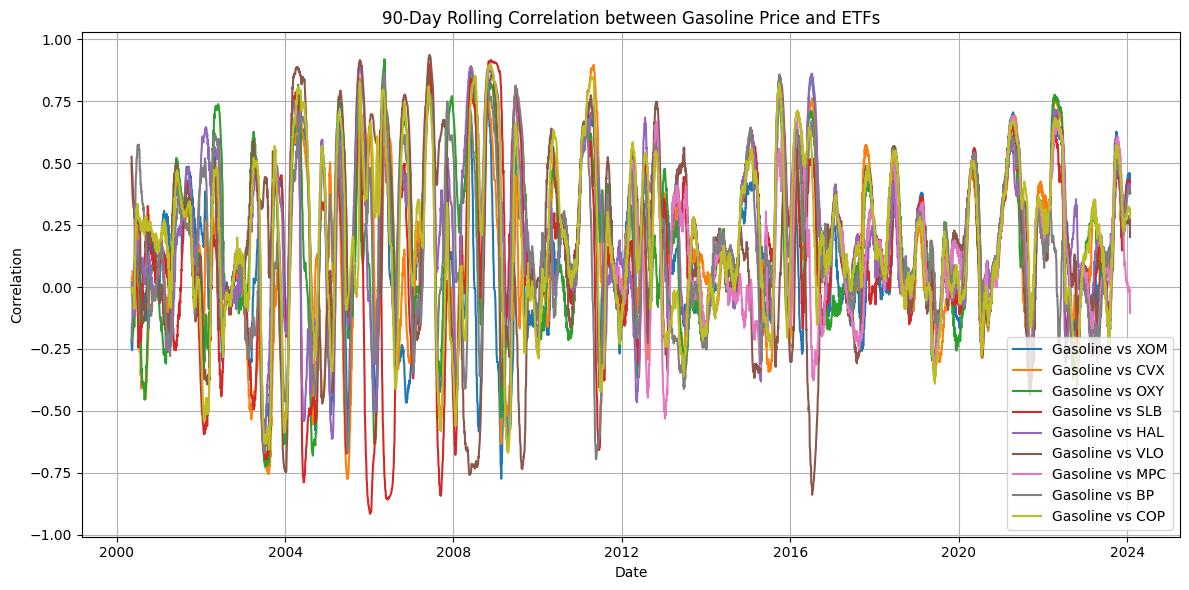

XOM rolling correlation std: 0.301
CVX rolling correlation std: 0.324
OXY rolling correlation std: 0.323
SLB rolling correlation std: 0.350
HAL rolling correlation std: 0.299
VLO rolling correlation std: 0.350
MPC rolling correlation std: 0.258
BP rolling correlation std: 0.304
COP rolling correlation std: 0.318


In [13]:
# Step 1: Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Step 2: Import libraries
import pandas as pd
import matplotlib.pyplot as plt

# Step 3: Load merged dataset
file_path = "/content/drive/My Drive/datathon 2025/merged_stock_and_gasoline.csv"
df = pd.read_csv(file_path)

# Step 4: Parse dates and clean
df['Date-Time'] = pd.to_datetime(df['Date-Time'])
df = df[['Date-Time', 'Ticker_Symbol', 'Close', 'Price']].dropna()

# Step 5: Pivot ETF data to wide format with Close prices
pivot_df = df.pivot_table(index='Date-Time', columns='Ticker_Symbol', values='Close', aggfunc='mean')

# Step 6: Merge gasoline price
gas_price = df.drop_duplicates(subset='Date-Time')[['Date-Time', 'Price']].set_index('Date-Time')
pivot_df = pivot_df.merge(gas_price, left_index=True, right_index=True)

# Step 7: Reconstruct rolling correlation and store each series
tickers = ['XOM', 'CVX', 'OXY', 'SLB', 'HAL', 'VLO', 'MPC', 'BP', 'COP']
window = 90
rolling_corrs = {}

plt.figure(figsize=(12, 6))

for ticker in tickers:
    if ticker in pivot_df.columns:
        corr_series = pivot_df[ticker].rolling(window=window).corr(pivot_df['Price'])
        rolling_corrs[ticker] = corr_series
        plt.plot(corr_series.dropna(), label=f'Gasoline vs {ticker}')

# Step 8: Plot
plt.title(f"{window}-Day Rolling Correlation between Gasoline Price and ETFs")
plt.ylabel("Correlation")
plt.xlabel("Date")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Step 9: Identify most stable ETF by correlation std
for ticker, series in rolling_corrs.items():
    std_val = series.dropna().std()
    print(f"{ticker} rolling correlation std: {std_val:.3f}")


In [14]:
# Step 10: Compute lagged correlation matrix
lags = range(-30, 31)
lagged_corrs = {ticker: [] for ticker in tickers}

for lag in lags:
    shifted_price = pivot_df['Price'].shift(lag)
    for ticker in tickers:
        if ticker in pivot_df.columns:
            corr = pivot_df[ticker].corr(shifted_price)
            lagged_corrs[ticker].append(corr)
        else:
            lagged_corrs[ticker].append(None)

# Step 11: Create summary table of max correlation and corresponding lag
lag_corr_df = pd.DataFrame(lagged_corrs, index=lags)

max_corr_info = []
for ticker in tickers:
    series = lag_corr_df[ticker]
    if series.notna().any():
        max_corr = series.max()
        best_lag = series.idxmax()
        max_corr_info.append((ticker, max_corr, best_lag))

max_corr_df = pd.DataFrame(max_corr_info, columns=['Ticker', 'MaxCorrelation', 'BestLag'])
max_corr_df = max_corr_df.sort_values(by='MaxCorrelation', ascending=False)

# Step 12: Save the summary table to Google Drive
output_path = "/content/drive/My Drive/datathon 2025/max_lagged_correlation_summary.csv"
max_corr_df.to_csv(output_path, index=False)
print(f"✅ Summary saved to: {output_path}")


✅ Summary saved to: /content/drive/My Drive/datathon 2025/max_lagged_correlation_summary.csv


<ipython-input-15-01f055ce2f1d>:31: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


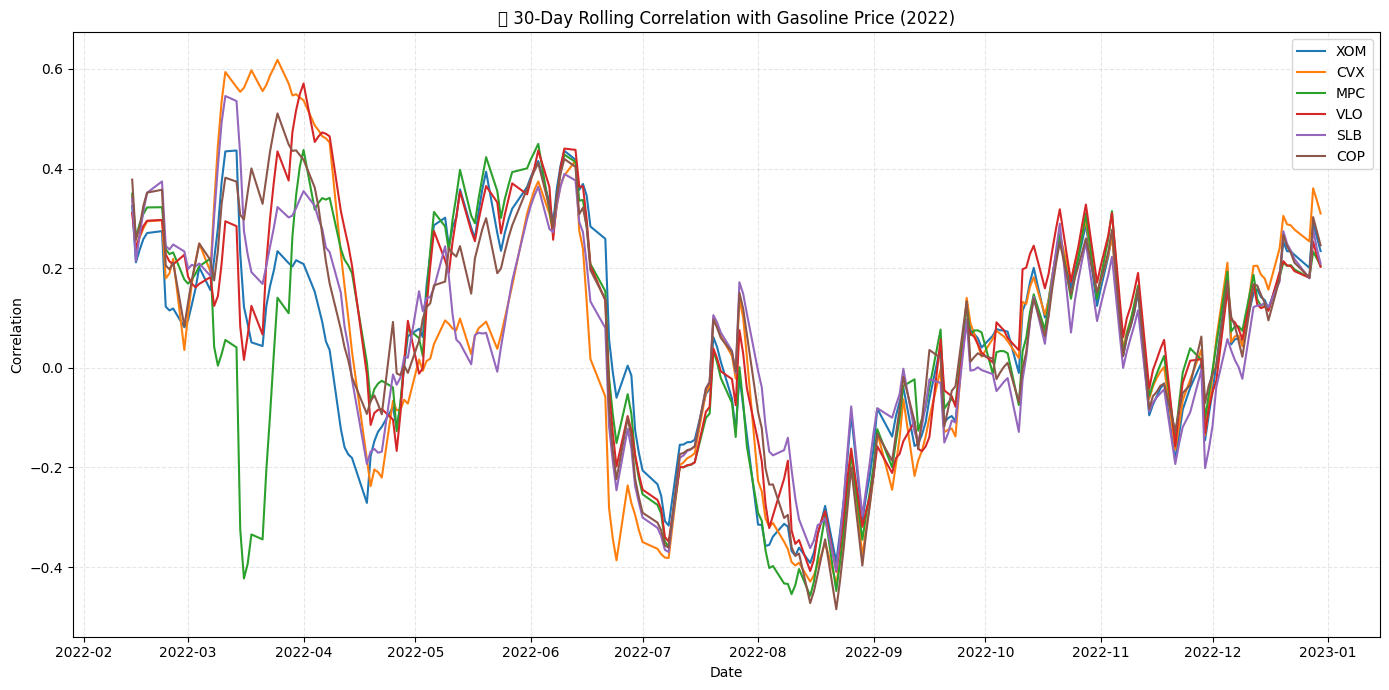

In [15]:
# Step 1: Filter 2022 data
df['Date-Time'] = pd.to_datetime(df['Date-Time'])
df_2022 = df[df['Date-Time'].dt.year == 2022]

# Step 2: Pivot & merge gasoline price
pivot_df_2022 = df_2022.pivot_table(index='Date-Time', columns='Ticker_Symbol', values='Close', aggfunc='mean')
gas_price = df_2022.drop_duplicates(subset='Date-Time')[['Date-Time', 'Price']].set_index('Date-Time')
pivot_df_2022 = pivot_df_2022.merge(gas_price, left_index=True, right_index=True)

# Step 3: Calculate 30-day rolling correlation
tickers = ['XOM', 'CVX', 'MPC', 'VLO', 'SLB', 'COP']
rolling_corrs = {}

for ticker in tickers:
    if ticker in pivot_df_2022.columns:
        corr = pivot_df_2022[ticker].rolling(window=30).corr(pivot_df_2022['Price'])
        rolling_corrs[ticker] = corr

# Step 4: Plot
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 7))
for ticker, series in rolling_corrs.items():
    plt.plot(series.dropna(), label=f"{ticker}")

plt.title("📈 30-Day Rolling Correlation with Gasoline Price (2022)")
plt.xlabel("Date")
plt.ylabel("Correlation")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()


While most energy-related stocks exhibited positive or at least weakly positive correlations with gasoline prices in 2022, several firms—particularly in the refining or oil services sector—experienced brief periods of negative correlation.
This likely reflects a margin squeeze or anticipated demand destruction, as higher gasoline prices can erode downstream profitability or reduce exploration incentives.

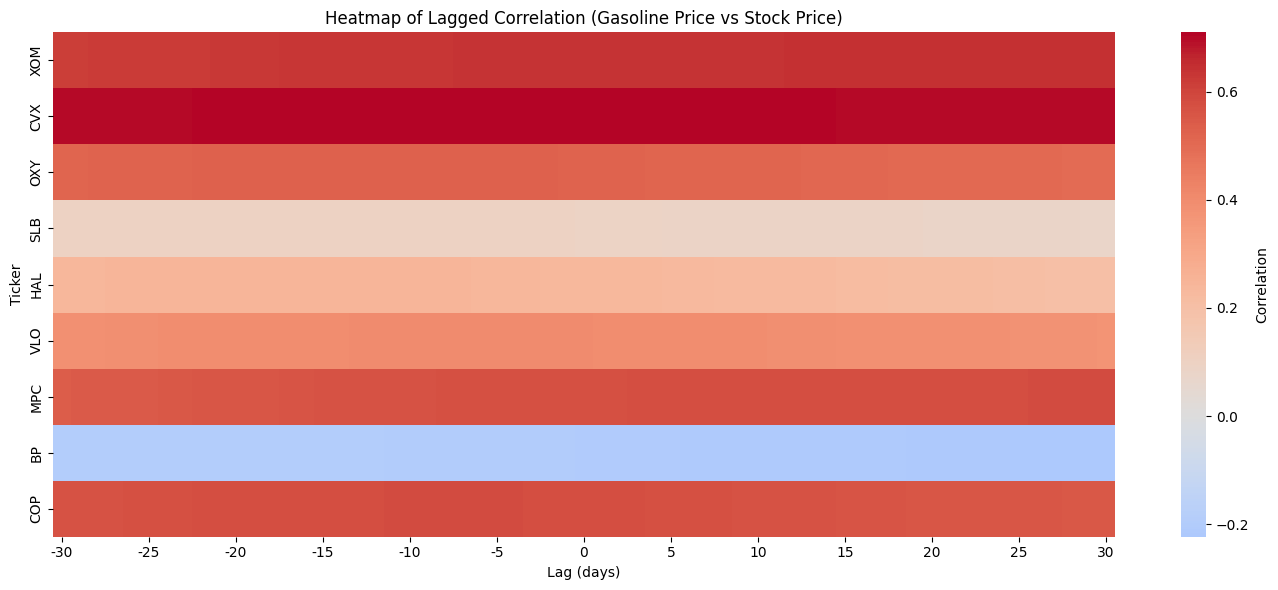

In [17]:
import seaborn as sns
# Step 3: Load data
file_path = "/content/drive/My Drive/datathon 2025/merged_stock_and_gasoline.csv"
df = pd.read_csv(file_path)

# Step 4: Preprocess
df['Date-Time'] = pd.to_datetime(df['Date-Time'])
df = df[['Date-Time', 'Ticker_Symbol', 'Close', 'Price']].dropna()

# Step 5: Pivot to wide format
pivot_df = df.pivot_table(index='Date-Time', columns='Ticker_Symbol', values='Close', aggfunc='mean')
gas_price = df.drop_duplicates(subset='Date-Time')[['Date-Time', 'Price']].set_index('Date-Time')
pivot_df = pivot_df.merge(gas_price, left_index=True, right_index=True)

# Step 6: Define tickers and lag range
tickers = ['XOM', 'CVX', 'OXY', 'SLB', 'HAL', 'VLO', 'MPC', 'BP', 'COP']
lags = range(-30, 31)

# Step 7: Calculate lagged correlations
lagged_corrs = {ticker: [] for ticker in tickers}

for lag in lags:
    shifted_price = pivot_df['Price'].shift(lag)
    for ticker in tickers:
        if ticker in pivot_df.columns:
            corr = pivot_df[ticker].corr(shifted_price)
            lagged_corrs[ticker].append(corr)
        else:
            lagged_corrs[ticker].append(np.nan)

# Step 8: Create DataFrame
lag_corr_df = pd.DataFrame(lagged_corrs, index=lags).T

# Step 9: Plot heatmap
plt.figure(figsize=(14, 6))
sns.heatmap(lag_corr_df, cmap='coolwarm', center=0, annot=False,
            cbar_kws={'label': 'Correlation'}, xticklabels=5)

plt.title("Heatmap of Lagged Correlation (Gasoline Price vs Stock Price)")
plt.xlabel("Lag (days)")
plt.ylabel("Ticker")
plt.tight_layout()
plt.show()
